# <font color='blue'>SENG 474 - Assignment  (Experiments and Analysis)</font>


Student Name:  Mek Obchey \
Student ID:    V00880355 \
Spring 2020


In [21]:
# Preprocessing - binary classification

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

df_train = pd.read_csv('data/fashion-mnist_train.csv')
df_test = pd.read_csv('data/fashion-mnist_test.csv')



X_train = df_train.iloc[:,1:]
y_train = df_train.iloc[:,0]

X_test = df_test.iloc[:,1:]
y_test = df_test.iloc[:,0]



# Rescale X_train and X_
X_train = X_train/255
X_test = X_test/255
        
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

# Remove all classes that are not 5 and 7 in the training set
s = []
fives = 0
sevens = 0
max_examples = 3000
for i in range(0, len(y_train)):
    if y_train[i] == 5 and fives < max_examples:
        s.append(i)
        fives += 1
    elif y_train[i] == 7 and sevens < max_examples:
        s.append(i)
        sevens += 1
X_train = X_train[s]
y_train = y_train[s]


# Remove all classes that are not 5 and 7 in the test set
s.clear()
for i in range(0, len(y_test)):
    if y_test[i] in {5, 7}:
        s.append(i)  
X_test = X_test[s]
y_test = y_test[s]

# Replace class 5 and 7 for binary classification
y_train[y_train == 5] = 0
y_train[y_train == 7] = 1
y_test[y_test == 5] = 0
y_test[y_test == 7] = 1


# Convert examples from 3D to 2D for Logistic Regression and SVM classifiers
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)


### Helper Functions

In [2]:
from matplotlib import pyplot as plt

# Calculate train vs test error of a classifier.
def calculate_errors(classifier, parameter, param_range, X_train, y_train, X_test, y_test):
    train_errors = list()
    test_errors = list()
    for i in param_range:
        eval('classifier.set_params(' + parameter + '=i)')
        classifier.fit(X_train, y_train)
        train_errors.append(classifier.score(X_train, y_train))
        test_errors.append(classifier.score(X_test, y_test))
    return (train_errors, test_errors)

def graph_train_test_errors(train_errors, test_errors, param, param_range, title):
    lw = 2
    plt.plot(param_range, train_errors, label="Train",color="darkorange", lw=lw)
    plt.plot(param_range, test_errors, label="Test",  color="navy", lw=lw)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.xlabel('Number of ' + param.upper())
    plt.ylabel('Accuracy')
    plt.autoscale()
    plt.show()
    
# shuffle two lists with same order
# Author: Francesco Montesano 
# source: https://stackoverflow.com/questions/23289547/shuffle-two-list-at-once-with-same-order
def shuffle_in_unison(a, b):
    n_elem = a.shape[0]
    indices = np.random.choice(n_elem, size=n_elem, replace=False)
    return a[indices], b[indices]

## <font color='black'> Analysis 1 : Logistic Regression</font>

Plot training vs test error using various regularization parameter C

In [87]:
# Please note: I tried to suppress the ConvergenceWarning with setting higher max_iter
# but it takes a long time to run 

# Parameter to test
param = 'C'
# param_range = np.logspace(-10, 0, 15)
param_range = np.logspace(-20, -1, 20)
classifier = LogisticRegression(penalty = 'l2', random_state = 0, max_iter = 3000)

train_errors, test_errors = calculate_errors(classifier, param, param_range, X_train, y_train, X_test, y_test)


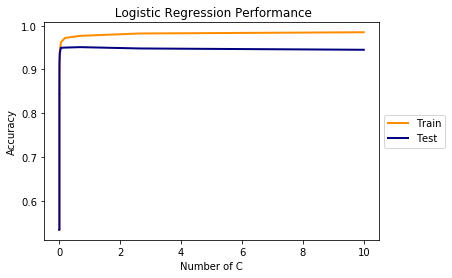

In [86]:
param_range
graph_train_test_errors(train_errors, test_errors, param, param_range, title=' Logistic Regression Performance')


## <font color='black'> Analysis 2 : Support Vector Machine</font>

In [77]:
param = 'C'
param_range = np.logspace(-10, -1, 10)

# Warning! The classifier takes up to 2 minutes to run

# penalty = 'l2' by default
classifier = SVC(kernel = 'linear', random_state = 0, max_iter = 100)

train_errors, test_errors = calculate_errors(classifier, param, param_range, X_train, y_train, X_test, y_test)


/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaco

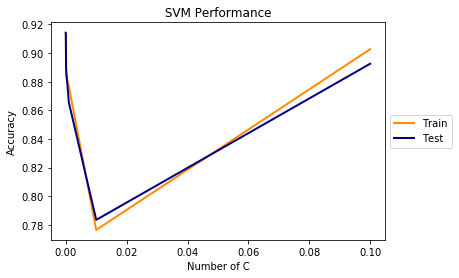

In [78]:
graph_train_test_errors(train_errors, test_errors, param, param_range, title=' SVM Performance ')


## <font color='black'> Analysis 3 - Cross Validation</font>


In [3]:
# Function used to calculate the average accuracy of a parameter using k-fold cross validation 

# Returns the average CV accuarcy of a set of parameters from a training dataset
def avg_cv_acc(classifier, param, param_range, k, X_train, y_train):
#     X_cv, y_cv = shuffle_in_unison(X_cv, y_cv)
#     Split dataset set into k folds
    X_cv = np.array(np.split(X_train, k))
    y_cv = np.array(np.split(y_train, k))
    avg_train_acc = {}
    avg_test_acc = {}
    
    # each parameter value
    for i in param_range:
        train_acc = []
        test_acc = []
        # each fold
        for j in range(0, k):
            excludes = [j != m for m in range(0, k)]
            X_train_cv = X_cv[excludes]
            y_train_cv = y_cv[excludes]

            X_train_cv = np.concatenate(X_train_cv) 
            y_train_cv = np.concatenate(y_train_cv)

            X_test_cv = X_cv[j]
            y_test_cv = y_cv[j]

            train_err, test_err = calculate_errors(classifier, param, [i], 
                                                 X_train_cv, y_train_cv, X_test_cv, y_test_cv)
            train_acc.append(train_err[0])
            test_acc.append(test_err[0])

        avg_train_acc[i] = sum(train_acc)/k
        avg_test_acc[i] = sum(test_acc)/k
        train_err.clear()
        test_err.clear()
    return avg_train_acc, avg_test_acc


## <font color='black'> Analysis 3-1 Cross Validation for Logistic Regression</font>

To find the optimal regularization parameter for a logistic regression classifier

In [60]:
# K-Fold CV, where 5 <= k <= 10   
k = 10

# Tuning parameter
param = 'C'
param_range = np.logspace(-3, 1, 20)

# takes about 30 seconds to run
logreg = LogisticRegression(penalty = 'l2', random_state = 0, max_iter = 100, multi_class = 'ovr')

logreg_avg_train_acc, logreg_avg_test_acc = avg_cv_acc(logreg, param, param_range,
                                                             k, X_train, y_train)



/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#

/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#

/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#

/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#

/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#

In [61]:
# Print CV result

print("C:\t\tAvg. Train Acc.\t\tAvg. Test Acc.")
for x in logreg_avg_train_acc:
    print('%3.4f\t\t%3.3f\t\t\t%3.3f' % (x, logreg_avg_train_acc.get(x), logreg_avg_test_acc.get(x)))



C:		Avg. Train Acc.		Avg. Test Acc.
0.0010		0.896			0.894
0.0016		0.906			0.904
0.0026		0.918			0.916
0.0043		0.927			0.925
0.0070		0.933			0.931
0.0113		0.940			0.936
0.0183		0.947			0.942
0.0298		0.955			0.950
0.0483		0.961			0.954
0.0785		0.965			0.957
0.1274		0.970			0.959
0.2069		0.973			0.960
0.3360		0.975			0.963
0.5456		0.977			0.963
0.8859		0.979			0.963
1.4384		0.981			0.961
2.3357		0.983			0.960
3.7927		0.984			0.957
6.1585		0.985			0.956
10.0000		0.986			0.955


In [72]:
C_optimal = [0.3360, 0.5456, 0.8859]
train_acc = []
test_acc = []

for i in C_optimal:
    svm = SVC(kernel = 'linear', C = i, random_state = 0, max_iter = 100)
    svm.fit(X_train, y_train)
    train_acc.append(svm.score(X_train, y_train))
    test_acc.append(svm.score(X_test, y_test))

print("Final Evaluation\nC\ttrain acc.\ttest acc.")
for i in range(0, len(C_optimal)):
    print("%.4f\t%.4f\t\t%.4f" % (C_optimal[i], train_acc[i], test_acc[i]))


/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Final Evaluation
C	train acc.	test acc.
0.3360	0.8028		0.7965
0.5456	0.8563		0.8610
0.8859	0.8645		0.8715


## <font color='black'> Analysis 3-2 Cross Validation for SVM </font>

To find the optimal regularization parameter for a SVM classifier

In [57]:
# Cross Validation Implementation


# X_train, y_train = shuffle_in_unison(X_train, y_train)

# K-Fold CV, where 5 <= k <= 10   
k = 10

# Tuning parameter
param = 'C'
param_range = np.logspace(-10, 1, 20)

# Warning! the classifier might takes more than 5 minutes to run

svm = SVC(kernel = 'linear', random_state = 0, max_iter = 100)

svm_avg_train_acc, svm_avg_test_acc = avg_cv_acc(svm, param, param_range,
                                                             k, X_train, y_train)

/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaco

/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaco

/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaco

/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaco

/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaco

/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaco

In [58]:
# Print CV result

print("C:\t\tAvg. Train Acc.\t\tAvg. Test Acc.")
for x in svm_avg_train_acc:
    print('%3.10f\t\t%3.3f\t\t\t%3.3f' % (x, svm_avg_train_acc.get(x), svm_avg_test_acc.get(x)))



C:		Avg. Train Acc.		Avg. Test Acc.
0.0000000001		0.880			0.878
0.0000000004		0.880			0.878
0.0000000014		0.880			0.878
0.0000000055		0.880			0.878
0.0000000207		0.880			0.878
0.0000000785		0.880			0.878
0.0000002976		0.880			0.878
0.0000011288		0.880			0.878
0.0000042813		0.881			0.878
0.0000162378		0.876			0.873
0.0000615848		0.878			0.877
0.0002335721		0.872			0.868
0.0008858668		0.860			0.857
0.0033598183		0.789			0.789
0.0127427499		0.757			0.760
0.0483293024		0.764			0.762
0.1832980711		0.852			0.846
0.6951927962		0.871			0.873
2.6366508987		0.871			0.873
10.0000000000		0.871			0.873


In [59]:
C_optimal = [0.0000000001,0.0000042813, 0.0008858668, 0.0033598183, 10.0000000000]


for c_val in C_optimal:
    svm = SVC(kernel = 'linear', C = c_val, random_state = 0, max_iter = 100)
    svm.fit(X_train, y_train)

    score1 = svm.score(X_train, y_train)
    score2 = svm.score(X_test, y_test)

    print("Final Evaluation C:%f\ntrain accuracy: %.4f\ttest accuracy: %.4f" % (c_val, score1, score2))

/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Final Evaluation C:0.000000
train accuracy: 0.9145	test accuracy: 0.9140


/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Final Evaluation C:0.000004
train accuracy: 0.9145	test accuracy: 0.9140


/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Final Evaluation C:0.000886
train accuracy: 0.8490	test accuracy: 0.8495


/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Final Evaluation C:0.003360
train accuracy: 0.7263	test accuracy: 0.7410


/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Final Evaluation C:10.000000
train accuracy: 0.8645	test accuracy: 0.8715


## <font color='black'> Part 4 : Kernelized SVMs with Gaussian Kernel</font>

In [46]:
# # Cross Validation Implementation


# Fourth. The final part of the assignment is to go beyond linear classifiers. For this, you’ll use
# kernelized SVMs with the Gaussian kernel. This kernel has a scale parameter (sometimes called
# a “bandwidth” parameter). For each value γ in a good range of values of the scale parameter
# (I suggest using a logarithmic spacing as you did with the regularization parameter), use k-fold
# cross-validation on the training set to select the optimal regularization parameter C γ . Now, for
# each (γ, C γ ) pair, you have a tuned SVM that can be trained. For each tuned SVM, train on the
# full training set and compute both the training error and the test error. Finally, plot the results.
# The x-axis will be γ, and the y-axis will be the training error (or test error) based on an SVM with
# parameters tuned to (γ, C γ ).
# How do these test errors compare to the test error of linear SVM (with regularization parameter
# tuned via cross-validation on the training set, which you already did)


# # K-Fold CV, where 5 <= k <= 10   
k = 5

# Tuning parameter (scale)
param = 'C'
C_range = np.logspace(-10, 1, 10)
gamma_range = np.logspace(-5, 1, 10)

# C_range = np.logspace(-6, 3, 10)
# gamma_range = np.logspace(-2, 2, 5)

svmg_train = {}
svmg_test = {}

# Warning! This part takes more than two hours to run!!
for i in gamma_range:
    svmg = SVC(kernel = 'rbf', gamma = i, random_state = 0, max_iter = 100)
    svmg_train_param = {}
    svmg_test_param = {}
    for j in C_range:
        svmg_avg_train_acc, svmg_avg_test_acc = avg_cv_acc(svmg, param, [j], k, X_train, y_train)
        svmg_train_param[j] = svmg_avg_train_acc
        svmg_test_param[j] = svmg_avg_test_acc
    svmg_train[i] = svmg_train_param
    svmg_test[i] = svmg_test_param


/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaco

/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaco

/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaco

/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaco

/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaco

/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaco

/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaco

/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaco

/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaco

/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaco

/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaco

/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaco

/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaco

/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaco

/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaco

In [47]:
# Print CV result

print("Gamma:\t\tAvg. Train Acc.\t\tAvg. Test Acc.")
# for x in svmg_train:
#     print('%3.10f\t\t%3.3f\t\t\t%3.3f' % (x, svmg_train, svmg_test))

max_train_acc = {}
max_test_acc = {}

for i in svmg_train:
    c_train = svmg_train.get(i)
    c_test = svmg_test.get(i)
    acc = []
    print("%.4f\t\tC-Gamma\tAcc.\t\tC-Gamma\tAcc." % i, end="\n")
    flat_train = {}
    flat_test = {}
    for j in c_train:
        val_train = [float(x) for x in c_train.get(j).values()][0]
        val_test = [float(x) for x in c_test.get(j).values()][0]
        flat_train[j] = val_train
        flat_test[j] = val_test
    for j in flat_train:
        print("\t\t%.4f\t%.4f" % (j, flat_train.get(j)), end="")
        print("\t\t%.4f\t%.4f" % (j, flat_test.get(j)))
    maxkey_train = (max(flat_train, key=flat_train.get))
    maxkey_test = (max(flat_test, key=flat_test.get))
    max_train_acc[i] = maxkey_train
    max_test_acc[i] = maxkey_test
    print("\tMAX:\t%.4f\t%.4f" % (maxkey_train, flat_train.get(maxkey_train)), end="")
    print("\tMAX:\t%.4f\t%.4f\n\n" % (maxkey_test, flat_test.get(maxkey_test)))





Gamma:		Avg. Train Acc.		Avg. Test Acc.
0.0000		C-Gamma	Acc.		C-Gamma	Acc.
		0.0000	0.8719		0.0000	0.8682
		0.0000	0.8936		0.0000	0.8907
		0.0000	0.8909		0.0000	0.8890
		0.0000	0.8909		0.0000	0.8890
		0.0000	0.8909		0.0000	0.8890
		0.0001	0.8909		0.0001	0.8890
		0.0022	0.8909		0.0022	0.8890
		0.0359	0.8909		0.0359	0.8890
		0.5995	0.8872		0.5995	0.8852
		10.0000	0.8597		10.0000	0.8565
	MAX:	0.0000	0.8936	MAX:	0.0000	0.8907


0.0000		C-Gamma	Acc.		C-Gamma	Acc.
		0.0000	0.8661		0.0000	0.8588
		0.0000	0.8775		0.0000	0.8748
		0.0000	0.8748		0.0000	0.8723
		0.0000	0.8748		0.0000	0.8723
		0.0000	0.8748		0.0000	0.8723
		0.0001	0.8748		0.0001	0.8723
		0.0022	0.8748		0.0022	0.8723
		0.0359	0.8725		0.0359	0.8705
		0.5995	0.8723		0.5995	0.8723
		10.0000	0.8707		10.0000	0.8707
	MAX:	0.0000	0.8775	MAX:	0.0000	0.8748


0.0002		C-Gamma	Acc.		C-Gamma	Acc.
		0.0000	0.8543		0.0000	0.8573
		0.0000	0.8673		0.0000	0.8707
		0.0000	0.8673		0.0000	0.8705
		0.0000	0.8673		0.0000	0.8705
		0.0000	0.8673		0.0000	0

In [51]:
svmg_eval_train_err = []
svmg_eval_test_err = []

# gamma
for i in max_test_acc:
    svmg_test = SVC(kernel = 'rbf', gamma = i, C = max_test_acc.get(i), random_state = 0, max_iter = 100)
    svmg_test.fit(X_train, y_train)
    svmg_eval_train_err.append(svmg_test.score(X_train, y_train))
    svmg_eval_test_err.append(svmg_test.score(X_test, y_test))



/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/matt/anaco

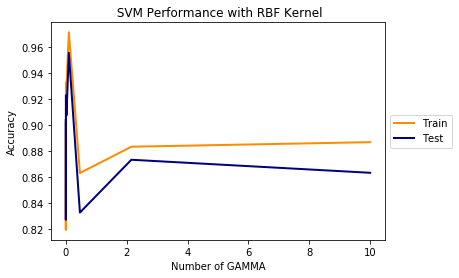

In [52]:
graph_train_test_errors(svmg_eval_train_err, svmg_eval_test_err, "Gamma", 
                        [i for i in max_test_acc], title=' SVM Performance with RBF Kernel')


In [56]:
print("Optimal gamma\t\tCgamma")
for i in max_train_acc:
    print('%.5f\t\t\t%.5f' % (i, max_train_acc.get(i)))

Optimal gamma		Cgamma
0.00001			0.00000
0.00005			0.00000
0.00022			0.00215
0.00100			0.03594
0.00464			10.00000
0.02154			10.00000
0.10000			10.00000
0.46416			0.59948
2.15443			0.59948
10.00000			0.59948
